# **Ahmed Nouralla - B19-CS-01 - a.shaaban@innopolis.university**
# **Machine Learning (F21) - Assignment 1**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **Practical Task 1**

### **Data Exploration**

In [ ]:
df = pd.read_csv('./task1_dataset.csv')
ground = pd.read_csv('./task1_dataset_full.csv')
df.describe()

Unnamed: 0            1            2            3
count  2000.000000  1417.000000  1417.000000  1417.000000
mean    999.500000    25.116156     0.073800     0.424997
std     577.494589    10.399268     0.720578     3.683166
min       0.000000     5.226627    -1.430905    -6.218775
25%     499.750000    16.489441    -0.582418    -3.431373
50%     999.500000    25.051147     0.151488     0.935197
75%    1499.250000    32.460457     0.714754     3.726296
max    1999.000000    55.008359     1.447426     6.176594

In [ ]:
# Renaming columns, just for convenience
df = df.rename(columns={"Unnamed: 0": "index",
             "0": "datetime", "1": "feature1",
             "2": "feature2", "3": "feature3"})
ground = ground.rename(columns={"Unnamed: 0": "index"})
df.head()

index             datetime   feature1  feature2  feature3
0      0  2017-02-10 07:00:00  25.618887 -0.932839  3.900162
1      1  2017-02-04 20:00:00  28.559832 -1.171867  0.223089
2      2  2017-02-18 16:00:00  31.390287  0.826090  2.069539
3      3  2017-01-15 08:00:00  14.205741 -0.921493  1.207404
4      4  2017-02-09 03:00:00  25.047604  0.294643  4.731710

In [ ]:
df.dtypes

index         int64
datetime     object
feature1    float64
feature2    float64
feature3    float64
dtype: object

In [ ]:
df.isna().sum() / df.count()

index       0.000000
datetime    0.000000
feature1    0.411433
feature2    0.411433
feature3    0.411433
dtype: float64

**Observations**:
1. Dataset contains 4 columns, the first one is just an index, the second one contains datetime (a categorical feature), and the last three contain numerical data.
2. Almost 40% of the data in each of the 3 numerical columns in missing.
3. Numerical data is independent from each other (given).

### **Categorical Features Encoding**

- The following code snippet will encode values in `datetime` column into numbers from [0, 1999] such that earlier dates have smaller corresponding encoded values.

- It will also sort samples by increasing datetime value for convenience.

In [ ]:
df["datetime"] = df["datetime"].astype('category')
df["datetime"] = df["datetime"].cat.codes
df.sort_values(by=['datetime'], inplace=True)

ground["datetime"] = ground["datetime"].astype('category')
ground["datetime"] = ground["datetime"].cat.codes
ground.sort_values(by=['datetime'], inplace=True)

df.head()

index  datetime  feature1  feature2  feature3
1999   1999         0       NaN       NaN       NaN
1327   1327         1  5.525603  0.149548  0.188817
1973   1973         2  5.724147  0.089343  0.167879
1919   1919         3  5.226627 -0.050859  0.066940
605     605         4  5.648900  0.072186  0.229240

### **Data Visualization**

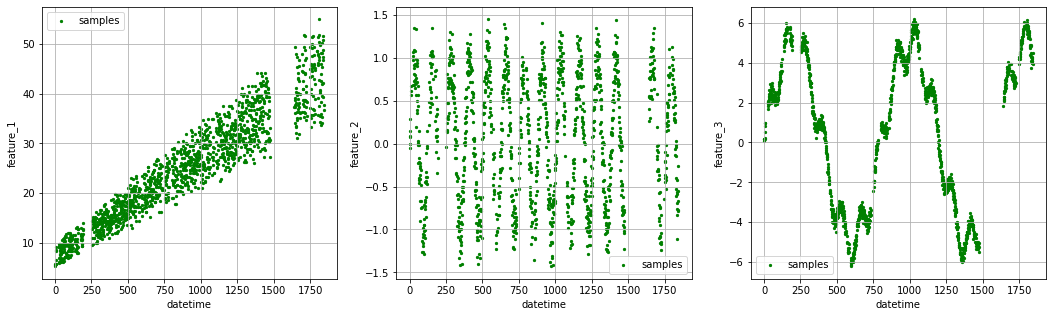

In [ ]:
plt.figure(figsize=(18, 5))

for i in range(1, 4):
  plt.subplot(1, 3, i)
  plt.scatter(df["datetime"], df[f"feature{i}"], s=5, label='samples', color='g')
  plt.xlabel("datetime")
  plt.ylabel(f"feature_{i}")
  plt.grid()
  plt.legend()

plt.show()

**Observations**
- It's obvious from the plots above that the data is following a certain pattern that we can utilize to fill the missing values.
- My initial guess is that, training a linear regression model will help predicting values for the first feature, while higher degree models will be required for the second and third features.

### **Data Imputation Using Polynomial Regression**
We need to:
1. Train several Polynomial Regression models (with multiple degrees from [1-10]) on the present values from each of the 3 features.
2. Predict the missing values using the models.
3. Comapre the predictions with the actual values from the `ground` dataset
4. Choose the model that minimizes MSE between prediction and test (ground truth).

In [ ]:
# Separating training and test data for each of the three features
x_train = {}
y_train = {}
x_test = {}
y_test = {}

for i in range(1, 4):
  x_train[i] = df[df[f"feature{i}"].notnull()][f"datetime"]
  y_train[i] = df[df[f"feature{i}"].notnull()][f"feature{i}"]
  x_test[i] = df[df[f"feature{i}"].isnull()]["datetime"]

  tmp = df[df[f"feature{i}"].isnull()].index
  test_rows = []
  for j in range(len(df.index)):
    if not (j in tmp):
      test_rows.append(-1)  # filling empty places to match lengths
    else:
      test_rows.append(j)

  y_test[i] = ground[ground["index"] == test_rows][f"feature{i}"]
 
  x_train[i] = x_train[i].values.reshape(-1, 1)
  y_train[i] = y_train[i].values.reshape(-1, 1)
  x_test[i] = x_test[i].values.reshape(-1, 1)

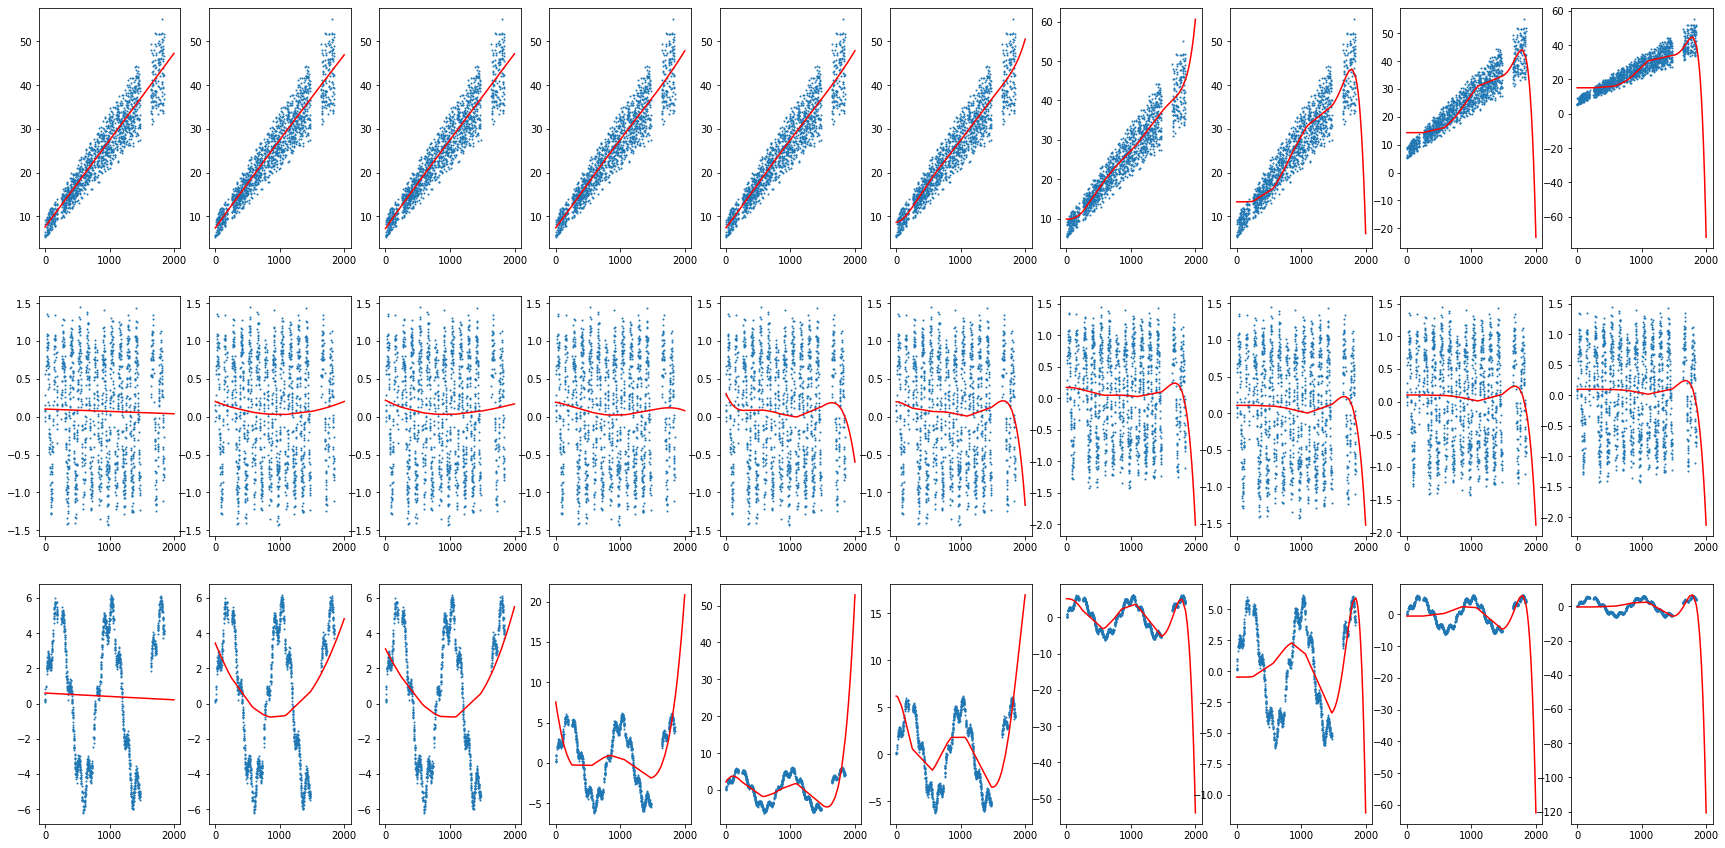

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Using polynomial regression to train the model
y_pred = {}
mse = {}
cnt = 1

plt.figure(figsize=(30, 15))

for i in range(1, 4):
  for degree in range(1, 11):
    poly_feats = PolynomialFeatures(degree=degree, include_bias=False)
    lin_reg = LinearRegression()

    pipeline = Pipeline([("1", poly_feats), ("2", lin_reg)])
    pipeline.fit(x_train[i], y_train[i])
    y_pred[i] = pipeline.predict(x_test[i])

    # imputed_df contains y_train + y_pred[i] for missing values, while ground
    # contains some y values that are not necessarily the same as y_train for a
    # certain datetime.
    # Task required plotting (MSE between imputed dataset and ground truth one).
    isnull = df[f'feature{i}'].isnull()
    imputed_df = df.copy()
    imputed_df.loc[isnull, f'feature{i}'] = y_pred[i]
    mse[(i, degree)] = mean_squared_error(ground[f'feature{i}'],
                                          imputed_df[f'feature{i}'])


    # However, it seems more logical to plot MSE between only test set and the
    # prediction done by the model (guesses for null values in the df)
    # mse[(i, degree)] = mean_squared_error(y_test[i], y_pred[i])

    plt.subplot(3, 10, cnt)
    cnt += 1
    plt.plot(x_test[i], y_pred[i], color='red')
    plt.scatter(df["datetime"], df[f"feature{i}"], s=1)
    
plt.show()

### **Model Evaluation and Conclusion**
It seems from the plots below that:
- For the first feature, the data seems the have a linear nature. Numerically, **the 5th degree** polynomial performed best, but there is not so big difference, **the linear model is still favorable** for it's simplicity.

- For the second feature, the data seems to follow a sinusoidal shape with high frequency, and we know that sin(x) can be described by an infinite power series, and since we cannot acheive that even with 10th degree, **the linear model** will work well in practice as an average.

- Third feature also follows a sinusoidal wave, but with lower frequency than the second one. Numerically, **the 2nd degree** polynomial performed best for that case, although there is not so big difference between it and **the linear model** and we still can prefer it for simplicity.

Minimal MSE for feature1 occurs at degree: 5
Minimal MSE for feature2 occurs at degree: 1
Minimal MSE for feature3 occurs at degree: 2


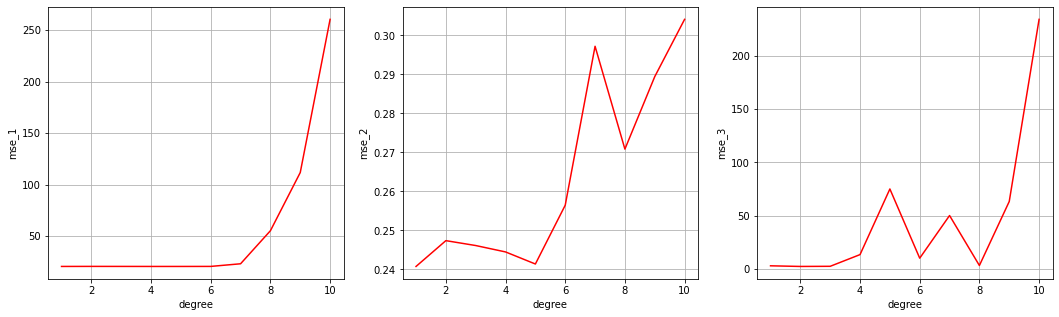

In [ ]:
# Plotting MSEs
plt.figure(figsize=(18, 5))

for i in range(1, 4):
  plt.subplot(1, 3, i)
  x_val = np.linspace(1, 10, 10)
  y_val = [mse[(i, y)] for y in range(1, 11)]

  print(f"Minimal MSE for feature{i} occurs at degree: {np.argmin(y_val)+1}")
  
  plt.plot(x_val, y_val, color='red')
  plt.xlabel("degree")
  plt.ylabel(f"mse_{i}")
  plt.grid()

plt.show()

## **Practical Task 2**

### **Data Exploration**

In [ ]:
# Adding attribute indices on top for easier manipulation (if not added before)
with open('./GermanData.csv', 'r') as f:
  if f.read(3) == 'A11':
    with open('./GermanData.csv', 'r+') as f:
      content = f.read()
      f.seek(0, 0)
      f.write(','.join([f'A{i}' for i in range(1, 21)]) + ',y\n' + content)

# Reading data from CSV file
df = pd.read_csv('./GermanData.csv')
df # Note: y=1 means that row is classified as good, y=2 -> bad.

A1  A2   A3   A4    A5   A6   A7  ...   A15  A16   A17  A18   A19   A20    y
0     A11   6  A34  A43  1169  A65  A75  ...  A152  2.0  A173  1.0  A192  A201  1.0
1     A12  48  A32  A43  5951  A61  A73  ...  A152  1.0  A173  1.0  A191  A201  2.0
2     A14  12  A34  A46  2096  A61  A74  ...  A152  1.0  A172  2.0  A191  A201  1.0
3     A11  42  A32  A42  7882  A61  A74  ...  A153  1.0  A173  2.0  A191  A201  1.0
4     A11  24  A33  A40  4870  A61  A73  ...  A153  2.0  A173  2.0  A191  A201  2.0
...   ...  ..  ...  ...   ...  ...  ...  ...   ...  ...   ...  ...   ...   ...  ...
1007  A14  12  A32  A42  1736  A61  A74  ...  A152  1.0  A172  1.0  A191  A201  1.0
1008  A11  30  A32  A41  3857  A61  A73  ...  A152  1.0  A174  1.0  A192  A201  1.0
1009  A14  12  A32  A43   804  A61  A75  ...  A152  1.0  A173  1.0  A191  A201  1.0
1010  A11  45  A32  A43  1845  A61  A73  ...  A153  1.0  A173  1.0  A192  A201  2.0
1011  A12  45  A34  A41  4576  A62  A71  ...  A152  1.0  A173  1.0  A191  A201  1.0

[1012 rows x 21 columns]

In [ ]:
types = df.dtypes
print(types)
print("#Categorical features: ", sum(types == 'object'))
print("#Numerical features: ", sum(types == 'float64') + sum(types == 'int64'))

A1      object
A2       int64
A3      object
A4      object
A5       int64
A6      object
A7      object
A8      object
A9      object
A10     object
A11    float64
A12     object
A13    float64
A14     object
A15     object
A16    float64
A17     object
A18    float64
A19     object
A20     object
y      float64
dtype: object
#Categorical features:  14
#Numerical features:  7


In [ ]:
# Manually fixing some Logical errors in the df
df['A2'] = df['A2'].astype(float)
df['A5'] = df['A5'].astype(float)
df.drop(df[df['A8'] == 'A192'].index, inplace=True)
df['A8'] = df['A8'].astype(float)
df['y'] = df['y'].astype(int)

In [ ]:
# Show description for numerical features
df.describe()

A2            A5  ...          A18            y
count  1011.000000   1011.000000  ...  1011.000000  1011.000000
mean     20.933729   3263.341246  ...     1.155292     1.297725
std      12.068721   2810.991220  ...     0.362362     0.457484
min       4.000000    250.000000  ...     1.000000     1.000000
25%      12.000000   1371.500000  ...     1.000000     1.000000
50%      18.000000   2319.000000  ...     1.000000     1.000000
75%      24.000000   3965.500000  ...     1.000000     2.000000
max      72.000000  18424.000000  ...     2.000000     2.000000

[8 rows x 8 columns]

In [ ]:
# Show description for categorical features
df.describe(exclude=np.number)

A1    A3    A4    A6    A7    A9  ...   A12   A14   A15   A17   A19   A20
count   1011  1011  1011  1011  1011  1011  ...  1011  1011  1011  1011  1011  1011
unique     4     5    10     5     5     4  ...     4     3     3     4     2     2
top      A14   A32   A43   A61   A73   A93  ...  A123  A143  A152  A173  A191  A201
freq     399   537   285   609   341   556  ...   337   824   722   634   603   974

[4 rows x 13 columns]

### **Correlation Matrix**
It seems that features 2 (duration in month) and 5 (credit amount) are highly correlated, this can decrease regression performance as it'll be harder to tweak one parameter without changing the other.

AxesSubplot(0.125,0.125;0.62x0.755)


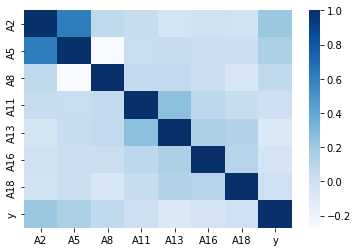

In [ ]:
import seaborn as sns
corr = df.corr()
print(sns.heatmap(corr, cmap="Blues"))

### **Data imputation**
- Fields representing unknown data will be replaced with NaNs
- Then impute the missing values (using mean for numerial features and most_frequent for categorical features)

In [ ]:
def nan_replace(feature, nan_val):
  if not df.get(feature) is None:
    df.loc[df[feature] == nan_val, feature] = np.nan

nan_replace('A1', 'A14')
nan_replace('A6', 'A65')
nan_replace('A12', 'A124')

In [ ]:
from sklearn.impute import SimpleImputer

num_df = df[['A2', 'A5', 'A8', 'A11', 'A13', 'A16', 'A18']]
cat_df = df[['A1', 'A3', 'A4', 'A6', 'A7', 'A9', 'A10', 'A12', 'A14', 'A15',
             'A17', 'A19', 'A20']]
y = df['y']

tmp = SimpleImputer(strategy='mean').fit_transform(num_df)
num_df = pd.DataFrame(tmp, columns=num_df.columns, index=num_df.index)

tmp = SimpleImputer(strategy='most_frequent').fit_transform(cat_df)
cat_df = pd.DataFrame(tmp, columns=cat_df.columns, index=cat_df.index)

df = pd.concat([num_df, cat_df], axis=1)
df = df.reindex(sorted(df.columns, key=lambda x: int(x[1:])), axis=1)
df = pd.concat([df, y], axis=1)
df

A1    A2   A3   A4      A5   A6  ...  A16   A17  A18   A19   A20  y
0     A11   6.0  A34  A43  1169.0  A61  ...  2.0  A173  1.0  A192  A201  1
1     A12  48.0  A32  A43  5951.0  A61  ...  1.0  A173  1.0  A191  A201  2
2     A11  12.0  A34  A46  2096.0  A61  ...  1.0  A172  2.0  A191  A201  1
3     A11  42.0  A32  A42  7882.0  A61  ...  1.0  A173  2.0  A191  A201  1
4     A11  24.0  A33  A40  4870.0  A61  ...  2.0  A173  2.0  A191  A201  2
...   ...   ...  ...  ...     ...  ...  ...  ...   ...  ...   ...   ... ..
1007  A11  12.0  A32  A42  1736.0  A61  ...  1.0  A172  1.0  A191  A201  1
1008  A11  30.0  A32  A41  3857.0  A61  ...  1.0  A174  1.0  A192  A201  1
1009  A11  12.0  A32  A43   804.0  A61  ...  1.0  A173  1.0  A191  A201  1
1010  A11  45.0  A32  A43  1845.0  A61  ...  1.0  A173  1.0  A192  A201  2
1011  A12  45.0  A34  A41  4576.0  A62  ...  1.0  A173  1.0  A191  A201  1

[1011 rows x 21 columns]

### **Categorical Feature Encoding**
It seems from the [description](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) of the categorical features that:
- For features (1, 6, 7, 15, 17); label encoding is appropriate, since they represent data that is comparable (some values have higher preference/precedence than others)
- For the rest of the categorical features (4, 9, 10, 12, 14, 20), using one-hot-encoding is ok, since values are not comparable and not too many categories exist. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def label_encoding(feature, cats):
  for i in range(cats + 1):
    df[feature].replace(f'{feature}{i+1}', i, inplace=True)

def one_hot_encoding(feature):
  if not df.get(feature) is None:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(df[df[feature].notnull()][[feature]])
    new_feats = encoder.transform(df[df[feature].notnull()][[feature]])
    new_cols = pd.DataFrame(new_feats, dtype=int)
    new_df = pd.concat([df, new_cols], axis=1)

    columns = {}
    for i in range(11):
      columns[i] = f'{feature}_{i}'    

    new_df.rename(columns=columns, inplace=True)
    new_df.drop(feature, axis=1, inplace=True)  
    return new_df

  else:
    return df

label_encoding('A1', 3)
label_encoding('A6', 4)
label_encoding('A7', 5)
label_encoding('A15', 3)
label_encoding('A17', 4)
label_encoding('A19', 2)

# One more unusal label encoding
for i in range(5):
    df['A3'].replace(f'A3{i}', 4-i, inplace=True)

df = one_hot_encoding('A4')
df = one_hot_encoding('A9')
df = one_hot_encoding('A10')
df = one_hot_encoding('A12')
df = one_hot_encoding('A14')
df = one_hot_encoding('A20')
df.dropna(inplace=True)
df

A1    A2   A3      A5   A6  ...  A14_0  A14_1  A14_2  A20_0  A20_1
0     0.0   6.0  0.0  1169.0  0.0  ...    0.0    0.0    1.0    1.0    0.0
1     1.0  48.0  2.0  5951.0  0.0  ...    0.0    0.0    1.0    1.0    0.0
2     0.0  12.0  0.0  2096.0  0.0  ...    0.0    0.0    1.0    1.0    0.0
3     0.0  42.0  2.0  7882.0  0.0  ...    0.0    0.0    1.0    1.0    0.0
4     0.0  24.0  1.0  4870.0  0.0  ...    0.0    0.0    1.0    1.0    0.0
...   ...   ...  ...     ...  ...  ...    ...    ...    ...    ...    ...
1006  0.0  12.0  2.0  2390.0  0.0  ...    0.0    0.0    1.0    1.0    0.0
1007  0.0  12.0  2.0  1736.0  0.0  ...    0.0    0.0    1.0    1.0    0.0
1008  0.0  30.0  2.0  3857.0  0.0  ...    0.0    0.0    1.0    1.0    0.0
1009  0.0  12.0  2.0   804.0  0.0  ...    0.0    0.0    1.0    1.0    0.0
1010  0.0  45.0  2.0  1845.0  0.0  ...    0.0    0.0    1.0    1.0    0.0

[1010 rows x 40 columns]

### **Feature Scaling**
- We can do standard scaling for all numerical features to ensure convergence of the logistic model.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

feats_to_scale = ['A2', 'A5', 'A8', 'A11', 'A13', 'A16', 'A18']
scaler = StandardScaler()
for i in feats_to_scale:
  df[i] = scaler.fit_transform(df[i].values.reshape(-1, 1))

### **Data Visualization**

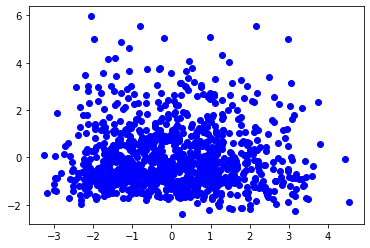

In [ ]:
from sklearn.decomposition import PCA

dim_reducer = PCA(n_components=2)
df_reduced = dim_reducer.fit_transform(df)
plt.scatter(df_reduced[:, 0], df_reduced[:, 1], color='blue')

plt.show()

### **Data Splitting**

In [ ]:
from sklearn.model_selection import train_test_split

x = df.drop('y', axis=1)
y = df['y']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, stratify=y, random_state=0)

### **Applying Logistic Regression**

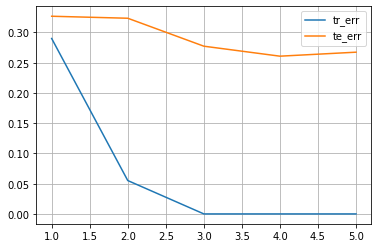

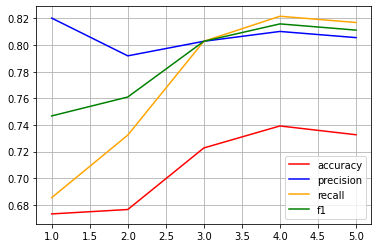

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
accuracy = []
precision = []
recall = []
f1 = []

tr_err = []
te_err = []

degrees = [i for i in range(1, 6)]

for degree in degrees:
    poly_feats = PolynomialFeatures(degree=degree)
    log_reg = LogisticRegression(random_state=0,
                                 class_weight='balanced',
                                 solver='liblinear')
    pipeline = Pipeline([("1", poly_feats), ("2", log_reg)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    te_err.append(mean_squared_error(y_pred, y_test))
    tr_err.append(mean_squared_error(pipeline.predict(x_train), y_train))
    
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))

plt.plot(degrees, tr_err, label='tr_err')
plt.plot(degrees, te_err, label='te_err')
plt.legend()
plt.grid()
plt.show()

plt.plot(degrees, accuracy, color='red', label="accuracy")
plt.plot(degrees, precision, color='blue', label="precision")
plt.plot(degrees, recall, color='orange', label="recall")
plt.plot(degrees, f1, color='green', label="f1")
plt.legend()
plt.grid()
plt.show()

**Observation:** It seems that the model of the **3rd** degree balances between the bias/variance, so we will use it

### **Optimizing hyperparameters**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# lbfgs solver doesn't support l1 penalty, so we split params
param_grid = [
    {
        '2__penalty': ['l2'],
        '2__solver':  ['lbfgs'],
        '2__C':       np.logspace(-4, 4, 20),
    },
    {
        '2__penalty': ['l1', 'l2'],
        '2__solver':  ['liblinear'],
        '2__C':       np.logspace(-4, 4, 20),
    },
]

poly_feats = PolynomialFeatures(degree=3)
log_reg = LogisticRegression(random_state=0, class_weight='balanced')
pipeline = Pipeline([("1", poly_feats), ("2", log_reg)])

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1'
                           )

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'2__C': 0.0001, '2__penalty': 'l1', '2__solver': 'liblinear'}


In [ ]:
best_model = grid_search.best_estimator_
best_model

Pipeline(memory=None,
         steps=[('1',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('2',
                 LogisticRegression(C=0.0001, class_weight='balanced',
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='auto',
                                    n_jobs=None, penalty='l1', random_state=0,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

### **Model Evaluation and Conclusion**

Comparing the accuracy of predictions across male and female applicants, we find that accuracy for predictions on males is higher.

This can be due to:
- The fact that the dataset has more specific fields for males (single, married, separater)
- Only one field (divorced/separated/married) and no samples with single females (A95) at all.

In [ ]:
x_test_male = x_test[x_test['A9_0'] + x_test['A9_2'] + x_test['A9_3'] > 0]
x_test_fem = x_test[x_test['A9_1'] > 0]

y_test_male = y_test[x_test_male.index]
y_test_fem =  y_test[x_test_fem.index]

y_pred_male = best_model.predict(x_test_male)
y_pred_fem = best_model.predict(x_test_fem)

print("Prediction accuracy for males:", accuracy_score(y_test_male, y_pred_male))
print("Prediction accuracy for females:", accuracy_score(y_test_fem, y_pred_fem))

Prediction accuracy for males: 0.7323232323232324
Prediction accuracy for females: 0.6476190476190476
